# Download Apple Watch data

This template provides example code for accessing and saving Apple Watch data. This includes accelerometry, rotation, and probability scores for tremor and dyskinesia.

In [1]:
import io
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from runeq import Config, stream

## Functions for pulling raw accelerometry, raw rotation, heart rate, dyskinesia probability, and tremor probability

In [2]:
def make_full_df(accessor):
    """Loop through pages of API calls and append to a single dataframe"""

    df = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        df = df.append(page_df, ignore_index=True)

    return df


def get_accel(client, params, save_filepath):
    """Makes API calls for accel data, saves to CSV and outputs dataframe"""

    accessor = client.Accel(**params)
    df = make_full_df(accessor)
    df.to_csv(save_filepath, index=False)

    return df


def get_rotation(client, params, save_filepath):
    """Makes API calls for rotation data, saves to CSV and outputs dataframe"""

    accessor = client.Rotation(**params)
    df = make_full_df(accessor)
    df.to_csv(save_filepath, index=False)

    return df


def get_tremor(client, params, save_filepath):
    """Makes API calls for tremor data, saves to CSV and outputs dataframe"""

    accessor = client.ProbabilitySymptom(
        symptom='tremor',
        severity='*',
        **params
    )
    df = make_full_df(accessor)
    df.to_csv(save_filepath, index=False)

    return df


def get_dyskinesia(client, params, save_filepath):
    """
    Makes API calls for dyskinesia data, saves to CSV and outputs
    dataframe
    """

    accessor = client.ProbabilitySymptom(
        symptom='dyskinesia',
        **params
    )
    df = make_full_df(accessor)
    df.to_csv(save_filepath, index=False)

    return df

def get_heartrate(client, params, save_filepath):
    """Makes API calls for hear rate data, saves to CSV and outputs dataframe"""

    accessor = client.HeartRate(**params)
    df = make_full_df(accessor)
    df.to_csv(save_filepath, index=False)

    return df

## 1. Initialize API credentials

First initialize your API credentials. These credentials are analogous to having a username/password for accessing patient data. You can set up an access token for read access to all patients within your organization. See our [API doc](https://docs.runelabs.io/stream/#section/Overview/Authentication) for instructions on how to set this up.

Next, set up a .yaml file with your token ID and secret. This is text file that will store your credentials. See our [`runeq` quickstart](https://runeq.readthedocs.io/en/latest/pages/quickstart.html#configuration) for how to set this up.

In [3]:
# set up client

cfg = Config()
client = stream.V1Client(cfg)

## 2. Specify endpoint parameters

In [4]:
params = {
    'patient_id': 'rcs07',
    'device_id': '0Z48CCdv',  # an Apple Watch
    # Use datetime to get timestamps from human-readable dates/times
    'start_time': datetime.datetime(2020, 11, 10, hour=20, minute=15).timestamp(),
    'end_time': datetime.datetime(2020, 11, 10, hour=21, minute=45).timestamp()
}

In [5]:
# specify base path for saving data

BASE_PATH = '~/Documents/api_data/'

## 3. Retrieve accelerometry, rotation, heart rate, tremor, and dyskinesia data

We will pass the client, our parameters, and a file path for saving our data into our functions above to obtain the CSV data. Be sure to change the file directories below.

In [6]:
accel = get_accel(
    client,
    params,
    os.path.join(BASE_PATH, 'nb02_ex01_accel.csv')
)
rotation = get_rotation(
    client,
    params,
    os.path.join(BASE_PATH, 'nb02_ex01_rotation.csv')
)
tremor = get_tremor(
    client,
    params,
    os.path.join(BASE_PATH, 'nb02_ex01_tremor.csv')
)
dyskinesia = get_dyskinesia(
    client,
    params,
    os.path.join(BASE_PATH, 'nb02_ex01_dyskinesia.csv')
)
heartrate = get_heartrate(
    client,
    params,
    os.path.join(BASE_PATH, 'nb02_ex01_heartrate.csv')
)

If loading previously downloaded data from CSV files:
```
accel = pd.read_csv(os.path.join(BASE_PATH, 'nb02_ex01_accel.csv'))
rotation = pd.read_csv(os.path.join(BASE_PATH, 'nb02_ex01_rotation.csv'))
tremor = pd.read_csv(os.path.join(BASE_PATH, 'nb02_ex01_tremor.csv'))
dyskinesia = pd.read_csv(os.path.join(BASE_PATH, 'nb02_ex01_dyskinesia.csv'))
heartrate = pd.read_csv(os.path.join(BASE_PATH, 'nb02_ex01_heartrate.csv'))
```

## 4. Plot watch data

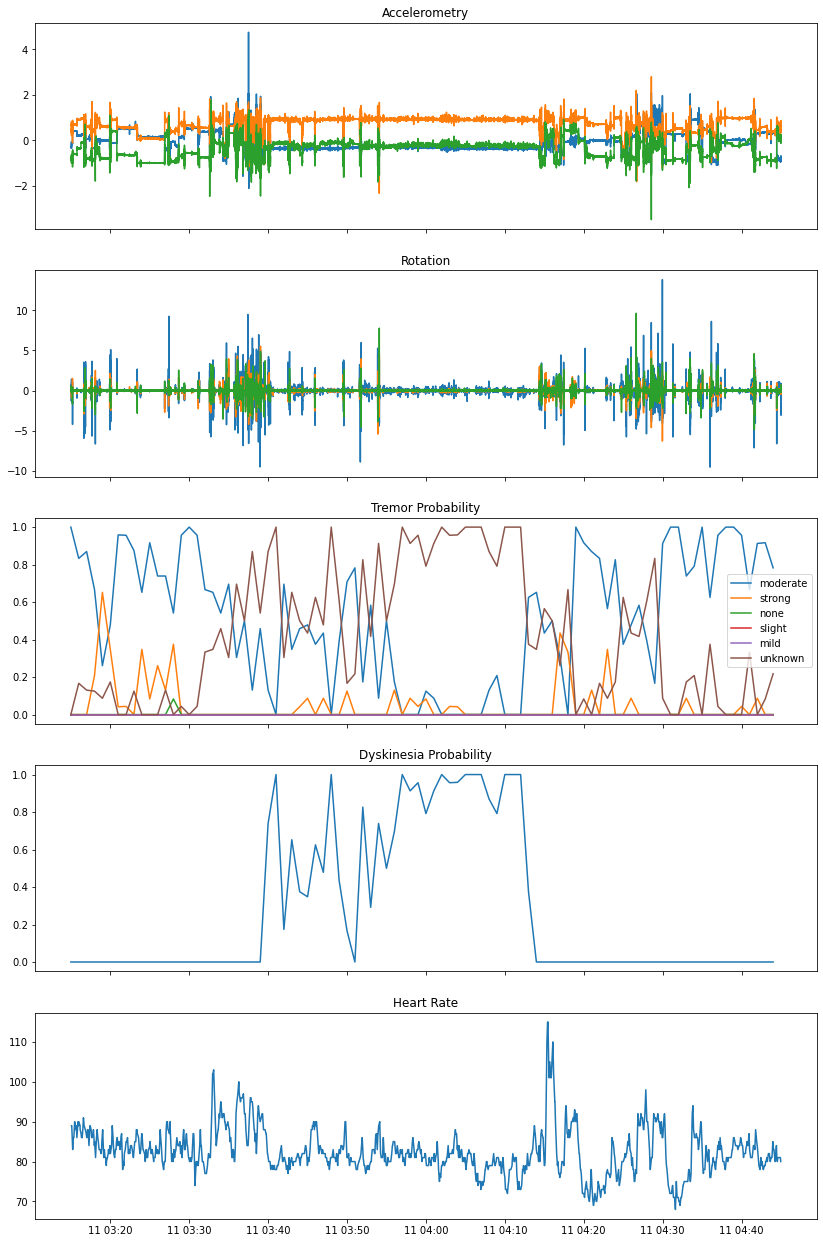

In [7]:
fig, ax = plt.subplots(5, figsize=(14, 22), sharex=True)

ax[0].plot(pd.to_datetime(accel.time, unit='s'), accel.x)
ax[0].plot(pd.to_datetime(accel.time, unit='s'), accel.y)
ax[0].plot(pd.to_datetime(accel.time, unit='s'), accel.z)
ax[0].set_title('Accelerometry')

ax[1].plot(pd.to_datetime(rotation.time, unit='s'), rotation.x)
ax[1].plot(pd.to_datetime(rotation.time, unit='s'), rotation.y)
ax[1].plot(pd.to_datetime(rotation.time, unit='s'), rotation.z)
ax[1].set_title('Rotation')

ax[2].plot(pd.to_datetime(tremor.time, unit='s'), tremor.none)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'), tremor.slight)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'), tremor.mild)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'), tremor.moderate)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'), tremor.strong)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'), tremor.unknown)
ax[2].set_title('Tremor Probability')
ax[2].legend({'none', 'slight', 'mild', 'moderate', 'strong', 'unknown'})

ax[3].plot(pd.to_datetime(dyskinesia.time, unit='s'), dyskinesia.probability)
ax[3].set_title('Dyskinesia Probability')

ax[4].plot(pd.to_datetime(heartrate.time, unit='s'), heartrate.bpm)
ax[4].set_title('Heart Rate');

## 5. Filter watch data

With these dataframes, we can easily obtain the timestamps in which certain symptoms were present/absent.

In [8]:
# filter by dyskinesia probability
# ex. probability > 0.1
dyskinesia[dyskinesia.probability > 0.1]

# filter by tremor
# ex mild probability >0.1 or slight probability > 0.1
tremor[(tremor.mild > 0.1) | (tremor.slight > 0.1)]

,time,mild,moderate,none,slight,strong,unknown
3,1.605065e+09,0.000000,0,0.666667,0.208333,0,0.125000
4,1.605065e+09,0.000000,0,0.260870,0.652174,0,0.086957
5,1.605065e+09,0.000000,0,0.478261,0.347826,0,0.173913
9,1.605065e+09,0.000000,0,0.652174,0.347826,0,0.000000
11,1.605065e+09,0.000000,0,0.739130,0.260870,0,0.000000
12,1.605065e+09,0.000000,0,0.739130,0.130435,0,0.130435
13,1.605065e+09,0.083333,0,0.541667,0.375000,0,0.000000
35,1.605067e+09,0.000000,0,0.708333,0.125000,0,0.166667
41,1.605067e+09,0.000000,0,0.173913,0.130435,0,0.695652
62,1.605068e+09,0.000000,0,0.304348,0.434783,0,0.260870
